# Lick model

### This notebook is an initial attempt to model trains of licks when rats are choosing between two solutions (e.g. protein and carbohydrate)

In [1]:
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
%run helperfx

In [2]:
use_real_data = True
simulate_data = True
fit_data = True

# set parameters for simulated data
if simulate_data:
    PP = 0.8
    tau = 3

# set bounds for fitting data
if fit_data:
    bounds = {'PP':[0, 1, 20], 'tau':[0.5, 40, 20]}

    boundbins = []
    boundbins.append(np.arange(bounds['PP'][0], bounds['PP'][1], bounds['PP'][1]/bounds['PP'][2]))
    boundbins.append(np.arange(bounds['tau'][0], bounds['tau'][1], bounds['tau'][1]/bounds['tau'][2]))

if use_real_data and simulate_data:
    print('Over-riding simulate_data because use_real_data is selected.')
    simulate_data = False

Over-riding simulate_data because use_real_data is selected.


In [3]:
# This function will be called when simulating test data and data for performing fits

def runmodel(PP, tau, nruns):
    
    # Create system with vars of interest
    System = {}
    System['PP'] = PP
    System['tau'] = tau
    System['licksinburst'] = 0
    
    # Initializes array for storing data
    output = [0.5]

    for i in range(1, nruns):
        update_func(System, output)

    # print(np.mean([x-1 for x in licks if x>0]))
    
    return output

In [4]:
def update_func(System, licks):
    pp = System['PP']
    tau = System['tau']
    x = System['licksinburst']
    
    if licks[-1] == 0.5:
            if random.random() < pp:
                licks.append(1)            
            else:
                licks.append(0)
            System['licksinburst'] = x+1
    else:
        p_cont = math.exp(-x*(1/tau))
        if random.random() < p_cont:           
            licks.append(licks[-1])
            System['licksinburst'] = x+1
        else:
            licks.append(0.5)
            System['licksinburst'] = 0          

In [5]:
# Code to get data to be tested - either real or simulated    
    
# in future this will allow one to select subjects and experiments by including arguments for medfile location etc    
if use_real_data:
    %run extractlicks.ipynb
    ratkey = 'IPP3.11'
    licks = test1_data_PR[ratkey]

if simulate_data:
    print('Simulating data with values: PP...')
    ratkey = 'simulated_PP={0}_tau={1}'.format(PP,tau)
    licks = runmodel(PP, tau, 1000)

Extracted licks from Med data


In [6]:
test1_data_NR.keys()

dict_keys(['IPP3.1', 'IPP3.2', 'IPP3.5', 'IPP3.6', 'IPP3.9', 'IPP3.10'])

In [14]:
def analyse_licks(data, bins):
    
    caslicks = len([x for x in licks if x == 1])
    maltlicks = len([x for x in licks if x == 0])
    realPP = caslicks/(caslicks + maltlicks)
    
    burstarray = []
    tmp = []
    for i, x in enumerate(data):
        if x == 0.5:
            burstarray.append(tmp)
            tmp = []
        else:
            tmp.append(x)
    
    bursts = []
    hists = []
    cumsums = []
    cumsums_norm = []
    
    for code in [0, 1]: 
        b = [len(x) for x in burstarray[1:] if x[0]==code]
        h = np.histogram(b, bins=bins) # add binsize
        cs = np.cumsum(h[0])

        bursts.append(b)
        hists.append(h)
        cumsums.append(cs)
        
    cumsums_norm.append([(x/cumsums[0][-1])*(1-realPP) for x in cumsums[0]]) # makes cumsums norm'd to toal licks
    cumsums_norm.append([(x/cumsums[1][-1])*(realPP) for x in cumsums[1]])
    
    return ({'licks':data, 'bursts':bursts, 'hists':hists, 'cumsums':cumsums, 'cumsums_norm':cumsums_norm, 'realPP':realPP })

In [15]:
nruns=5000

# licks = runmodel(0.5, 18, nruns)

histbins = np.arange(0,100)
lickdata = analyse_licks(licks, histbins)

In [16]:
def fit(lickdata, boundbins, histbins, nruns=1000, fittype='hist'):
    print('Fitting data using bounds provided.')

    nPP = bounds['PP'][2]
    ntau = bounds['tau'][2]
    
    grid = np.empty((nPP,ntau,))
    
    pp_matrix = boundbins[0]
    tau_matrix = boundbins[1]
    
    for pp_idx, pp in enumerate(pp_matrix):
        for tau_idx, tau in enumerate(tau_matrix):
            comparison_data = runmodel(pp, tau, nruns)
            licks_to_fit = analyse_licks(comparison_data, histbins)
            
            #work out loglik for hist bins using compare function and place this value in the grid
            
            diffs = []
            
            # To use histograms for comparison with model
            if fittype == 'hist':
                for bottle in [0, 1]:
                    data = lickdata['hists'][bottle][0]
                    comp = licks_to_fit['hists'][bottle][0]         
                    diffs.append(sum([np.abs(x-y) for x,y in zip(data, comp)]))
            else:
            # To use cumulative distributions for comparison with model
                for bottle in [0, 1]:
                    data = lickdata['cumsums_norm'][bottle]
                    comp = licks_to_fit['cumsums_norm'][bottle]       
                    diffs.append(sum([np.abs(x-y) for x,y in zip(data, comp)]))
            
            grid[pp_idx, tau_idx] = sum(diffs)
    
    grid = 1/grid
    
    tmp = np.sum(grid, axis=1)
    pp_marglik = tmp/sum(tmp)
    pp_ML = boundbins[0][np.argmax(pp_marglik)]
    pp_EV = sum(boundbins[0]*pp_marglik)
    
    tmp = np.sum(grid, axis=0)
    tau_marglik = tmp/sum(tmp)
    tau_ML = boundbins[1][np.argmax(tau_marglik)]
    tau_EV = sum(boundbins[1]*tau_marglik)
    
    fitted = {'grid':grid,
              'pp_marglik': pp_marglik, 'pp_ML':pp_ML, 'pp_EV':pp_EV,
              'tau_marglik': tau_marglik, 'tau_ML':tau_ML, 'tau_EV':tau_EV}
    
    return fitted

Fitting data using bounds provided.


C:\ProgramData\Anaconda3\envs\lickmodel\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars


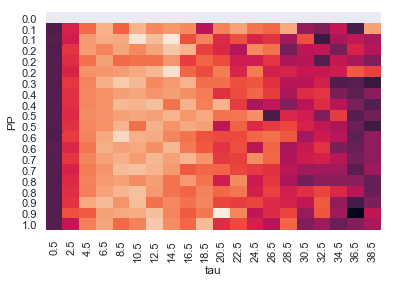

In [17]:
nruns = len(licks)
if fit_data:
    fitted = fit(lickdata, boundbins, histbins, nruns=nruns, fittype='cumsums')

    gridscores = fitted['grid']

    #gridscores=new

    pp_matrix = np.arange(bounds['PP'][0], bounds['PP'][1], bounds['PP'][1]/bounds['PP'][2])
    tau_matrix = np.arange(bounds['tau'][0], bounds['tau'][1], bounds['tau'][1]/bounds['tau'][2])

    pp_vals = ["{:.1f}".format(x) for x in pp_matrix]
    tau_vals = ["{:.1f}".format(x) for x in tau_matrix]

    import seaborn as sns; sns.set()
    ax = sns.heatmap(np.log(gridscores), cbar=False, xticklabels=tau_vals, yticklabels=pp_vals)
    ax.set_xlabel('tau')
    ax.set_ylabel('PP')


Estimated PP= nan  and estimated tau= nan  using EV
Estimated PP= 0.0  and estimated tau= 0.5  using ML


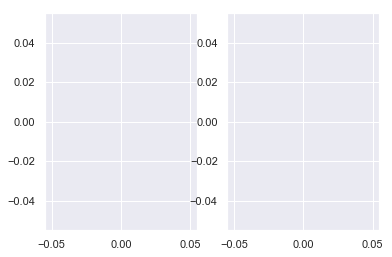

In [18]:
if fit_data:
    f, ax = plt.subplots(ncols=2)
    ax[0].plot(fitted['pp_marglik'])
    ax[1].plot(fitted['tau_marglik'])

    print('Estimated PP=', fitted['pp_EV'], ' and estimated tau=', fitted['tau_EV'], ' using EV')
    print('Estimated PP=', fitted['pp_ML'], ' and estimated tau=', fitted['tau_ML'], ' using ML')

In [31]:
def timecourseFig(lickdata, ax=[]):

    x1 = [i for i, x in enumerate(lickdata['licks']) if x == 1]
    x2 = [i for i, x in enumerate(lickdata['licks']) if x == 0]

    y1 = [1]*len(x1)
    y2 = [0]*len(x2)

    ax.plot(x1,y1, 'x')
    ax.plot(x2,y2, 'x')

    # plots real PP
    x1=0; x2=len(lickdata['licks']); y=lickdata['realPP']
    ax.plot([x1, x2], [y, y], linestyle='dashed')
    ax.text(x2,y,'Real PP', va='center' )
    
    if fit_data:
        print('Fitted')
        ax.plot(np.arange(0,len(licks)),[fitted['pp_EV']]*len(licks), 'r', linestyle='dashed')

    #ax.plot(smooth(licks, 50), 'b')
    ax.plot(smooth2(licks, 50), 'r')

    ax.set_ylim([-0.1, 1.1])
    ax.set_xlabel('Licks')
    ax.set_ylabel('PP')
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels(['Malto', '0.5', 'Casein'])

def histoFig(lickdata, smooth=0, ax=[]):
    
    for index, color in zip([1,0], ['green', 'grey']):
        x = lickdata['hists'][index][1][1:-1]
        y = lickdata['hists'][index][0][1:]
        
        
        if smooth > 0:
            ax.plot(smooth2(y, smooth))
        else:
            ax.plot(x,y)
            
        ax.set_xlabel('Licks in burst')
        ax.set_ylabel('Frequency')
        
        meanCas = 'Casein={:.1f} licks/burst'.format(np.mean(lickdata['bursts'][1]))
        meanMalto = 'Malto={:.1f} licks/burst'.format(np.mean(lickdata['bursts'][0]))
        ax.text(0.95, 0.95, meanCas+'\n'+meanMalto,
                transform=ax.transAxes, ha='right', va='top')

def cumsumFig(lickdata, normed=False, ax=[]):
    
    if normed:
        datatoplot = lickdata['cumsums_norm']
        ylabel = 'Normd cum. frequency'
    else:
        datatoplot = lickdata['cumsums']
        ylabel = 'Cumulative frequency'
    
    for index, color in zip([1,0], ['green', 'grey']):
        ax.plot(datatoplot[index])
        
    ax.set_xlabel('Licks in burst')
    ax.set_ylabel(ylabel)

def makeSessionFig(savefig=False):
    f = plt.figure(figsize=(15,8))
    f.suptitle(ratkey)
    gs = gridspec.GridSpec(2, 3, hspace=0.3, wspace=0.3)

    ax1 = f.add_subplot(gs[0, :])
    timecourseFig(lickdata, ax=ax1)

    ax2 = f.add_subplot(gs[1,0])
    histoFig(lickdata, ax=ax2)
    #histoFig(lickdata, smooth=2, ax=ax3)

    ax3 = f.add_subplot(gs[1,1])
    cumsumFig(lickdata, ax=ax3)
    
    ax4 = f.add_subplot(gs[1,2])
    cumsumFig(lickdata, normed=True, ax=ax4)

    if savefig:
        savefolder = 'C:\\Users\\James Rig\\Dropbox\\AbstractsAndTalks\\2019-06-12_MOAB Lick microstructure\\figs\\'
        f.savefig(savefolder+ratkey+'_sessionfig.png')


Fitted


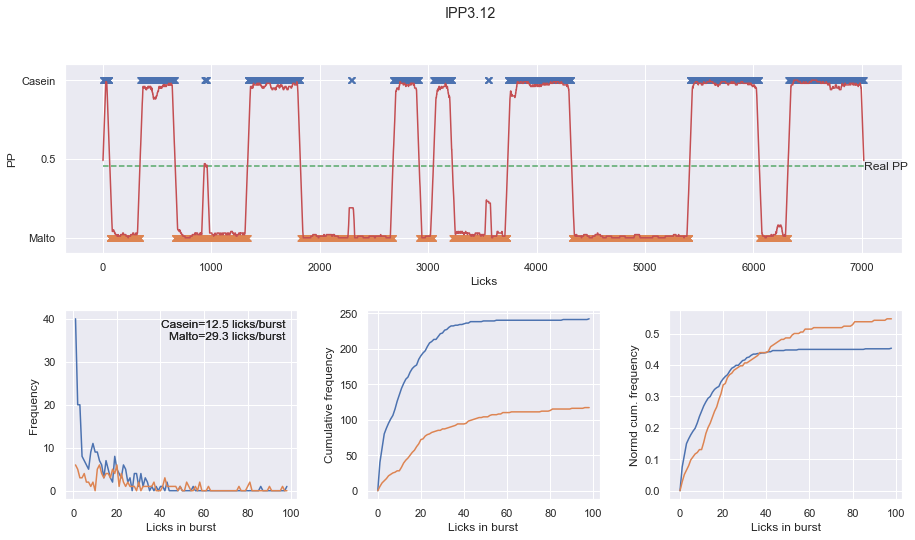

In [32]:
makeSessionFig()

<Figure size 432x288 with 0 Axes>

Extracted licks from Med data
Fitted
Fitted
Fitted
Fitted
Fitted
Fitted


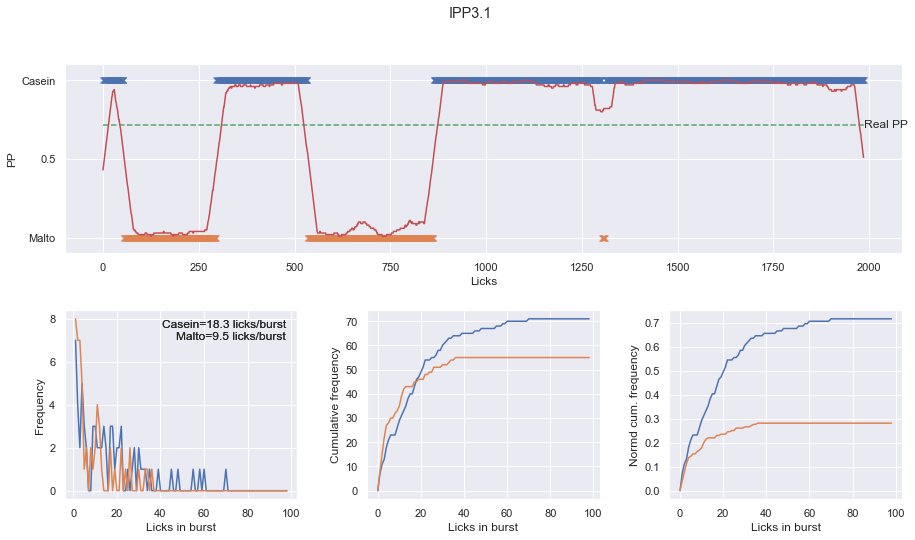

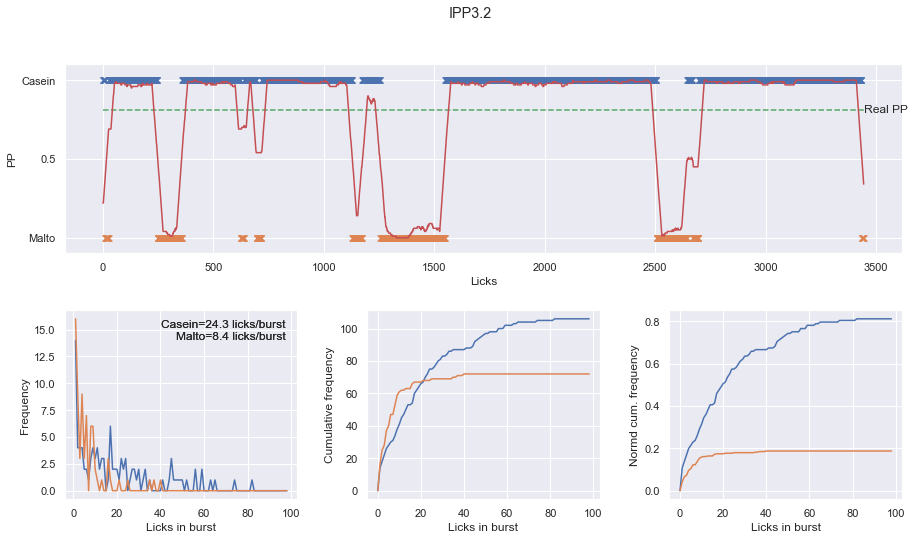

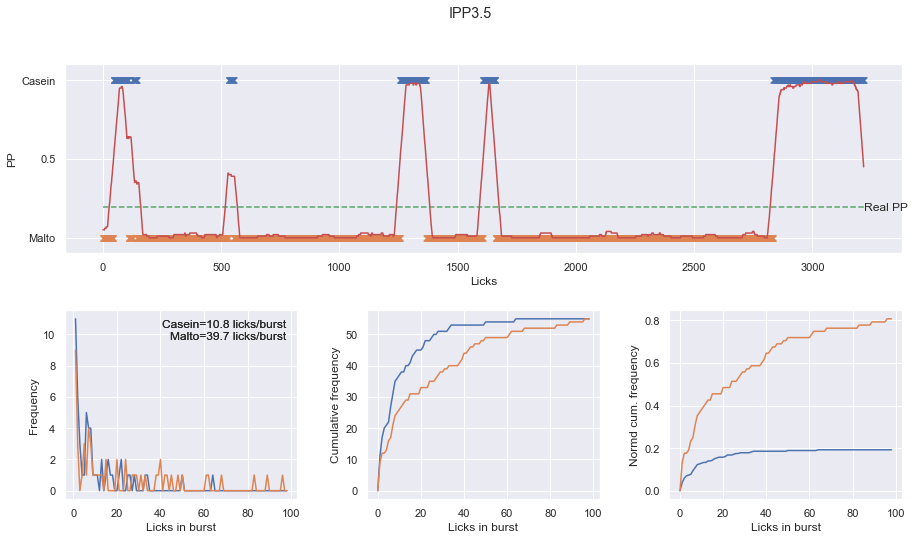

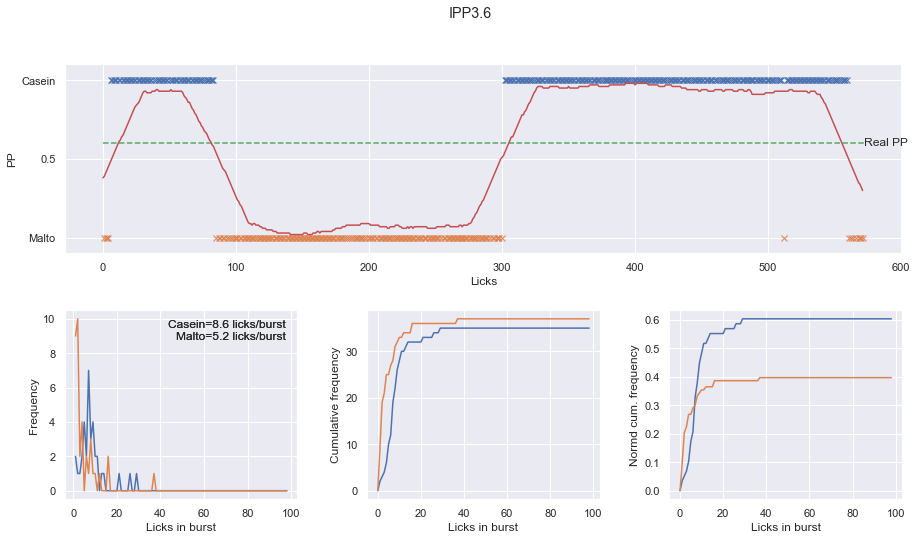

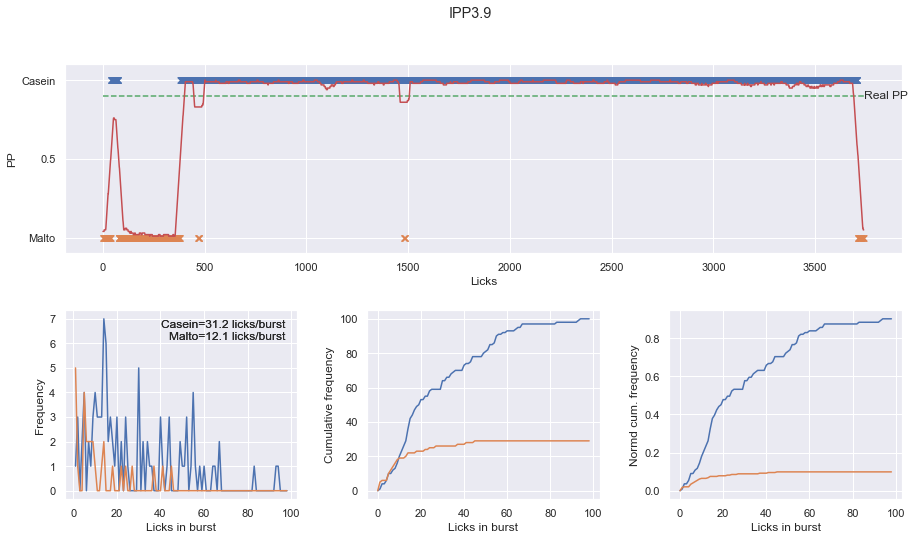

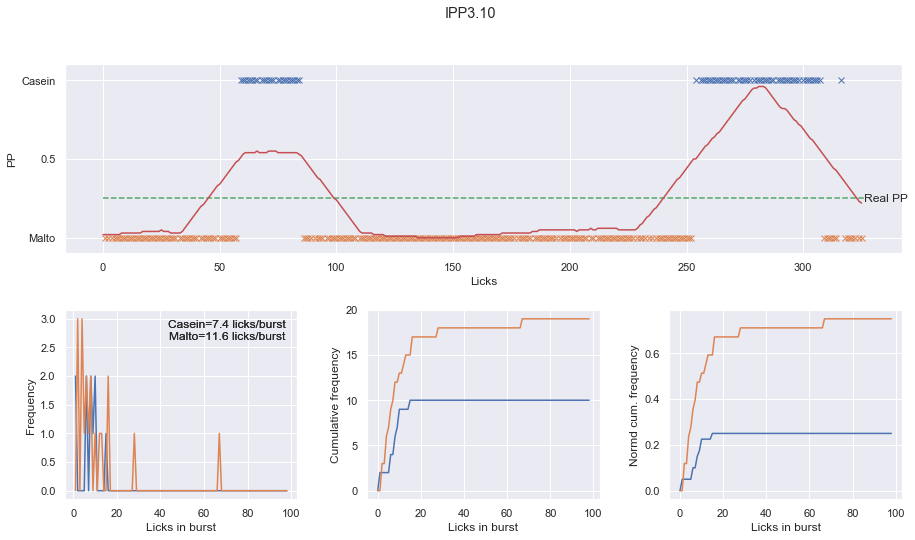

In [33]:
%run extractlicks.ipynb

# Data for NR rats
NRhists_cas = []
NRhists_malt = []
NR_PPs = []

for ratkey in test1_data_NR.keys():
    licks = test1_data_NR[ratkey]
    lickdata = analyse_licks(licks, histbins)
    NRhists_cas.append(lickdata['hists'][1][0])
    NRhists_malt.append(lickdata['hists'][0][0])
    NR_PPs.append(lickdata['realPP'])
    
    makeSessionFig(savefig=True)


Fitted
Fitted
Fitted
Fitted
Fitted
Fitted


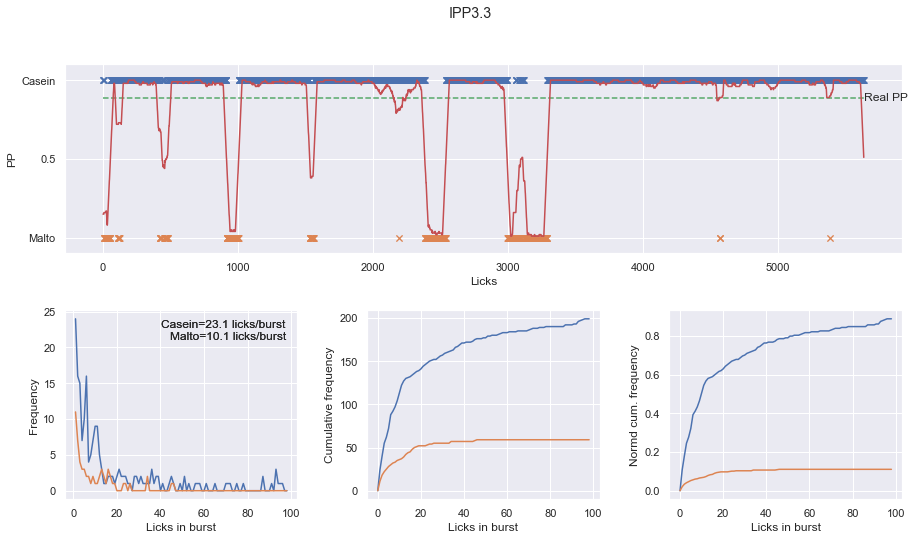

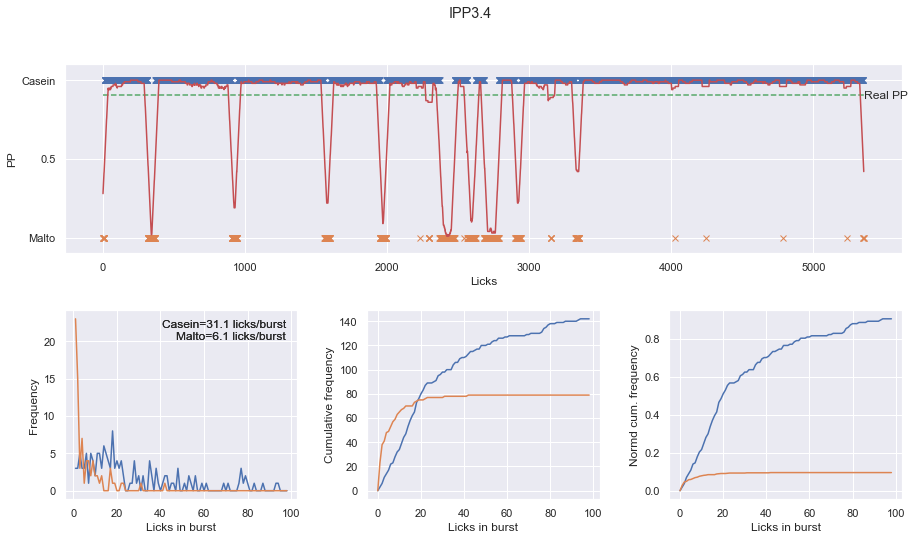

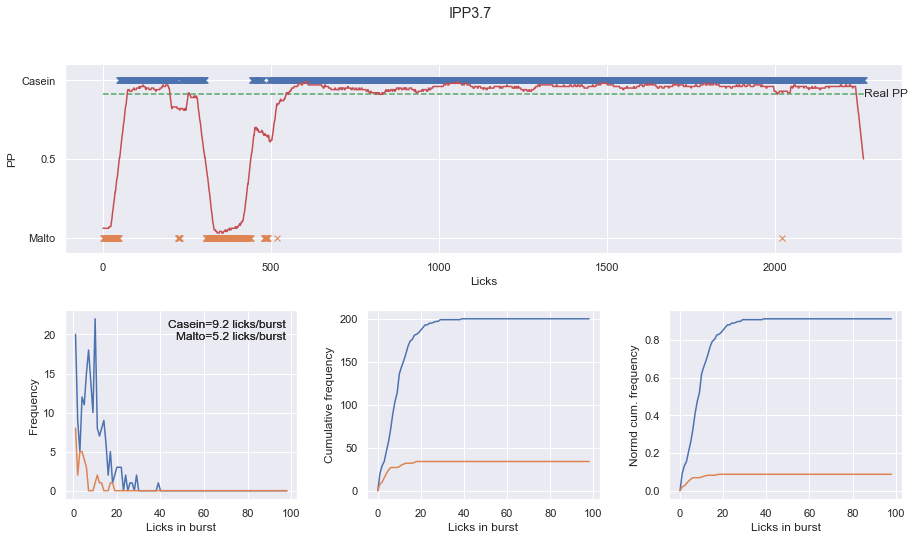

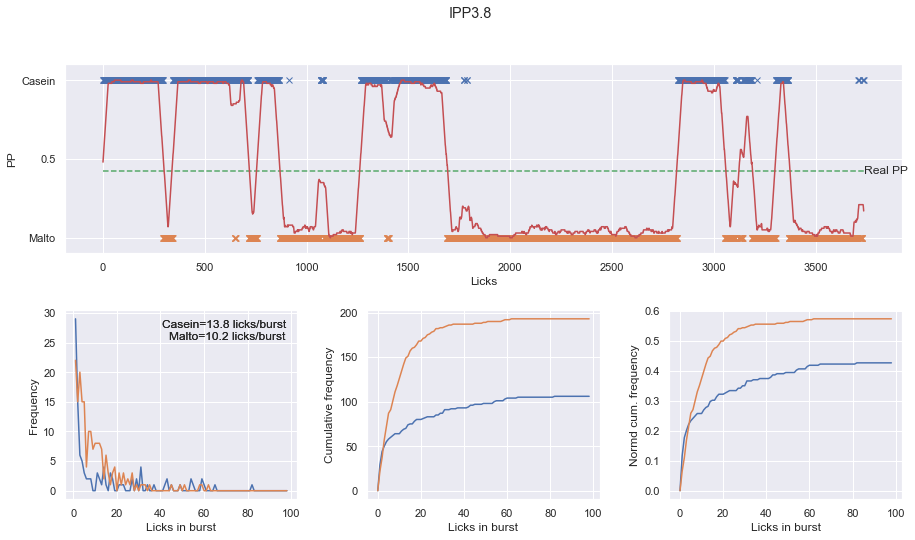

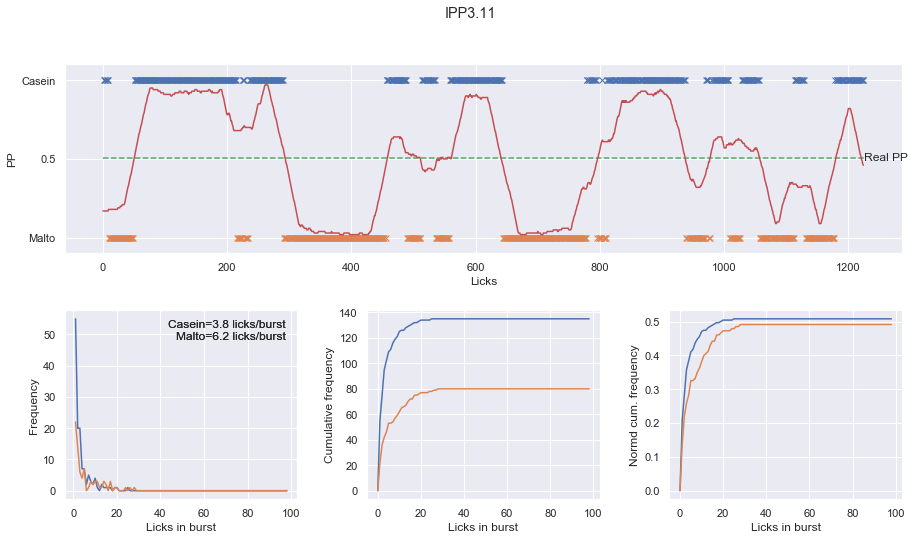

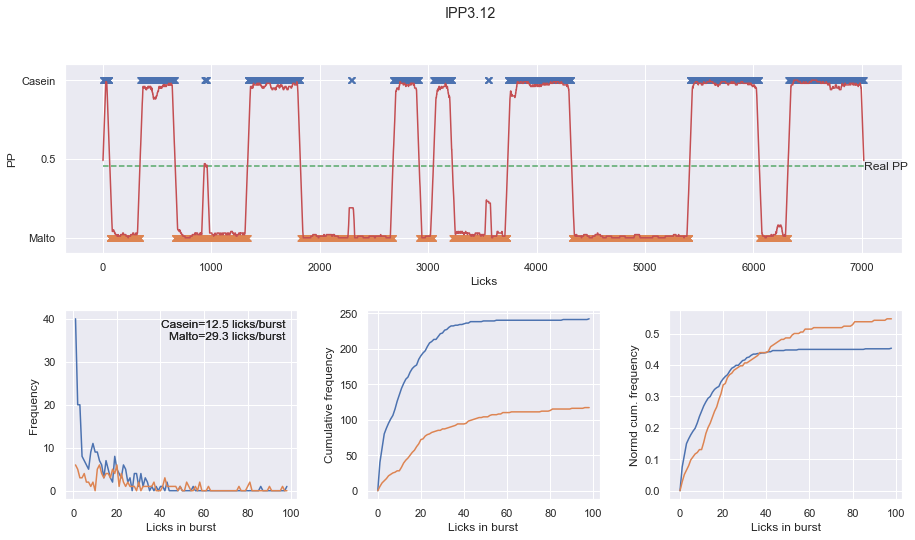

In [34]:
# Data for NR rats
PRhists_cas = []
PRhists_malt = []
PR_PPs = []

for ratkey in test1_data_PR.keys():
    licks = test1_data_PR[ratkey]
    lickdata = analyse_licks(licks, histbins)
    PRhists_cas.append(lickdata['hists'][1][0])
    PRhists_malt.append(lickdata['hists'][0][0])
    PR_PPs.append(lickdata['realPP'])
    
    makeSessionFig(savefig=True)

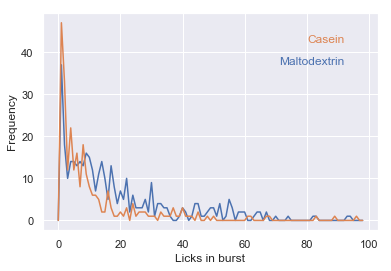

In [54]:
current_palette = sns.color_palette()

NRhists_cas_avg = np.sum(NRhists_cas, axis=0)
NRhists_malt_avg = np.sum(NRhists_malt, axis=0)

f, ax = plt.subplots()
ax.plot(NRhists_cas_avg)
ax.plot(NRhists_malt_avg)

ax.set_xlabel('Licks in burst')
ax.set_ylabel('Frequency')
ax.text(0.9, 0.9, 'Casein', color=current_palette[1], transform=ax.transAxes, ha='right', va='top')
ax.text(0.9, 0.8, 'Maltodextrin', color=current_palette[0], transform=ax.transAxes, ha='right', va='top')

savefolder = 'C:\\Users\\James Rig\\Dropbox\\AbstractsAndTalks\\2019-06-12_MOAB Lick microstructure\\figs\\'
f.savefig(savefolder+'allNR_hist.png')


30 30


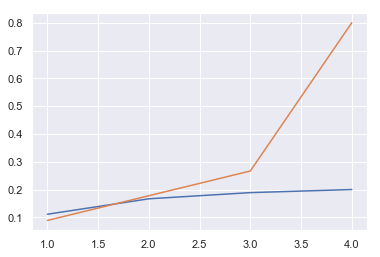

In [35]:
aaa = [10,5,2,1]
bbb = [1,1,1,6]

xxx = [1,2,3,4]
aaaN = sum([a*x for a,x in zip(aaa,xxx)])
bbbN = sum([b*x for b,x in zip(bbb,xxx)])

print(aaaN, bbbN)

aaaCS = np.cumsum(aaa)
bbbCS = np.cumsum(bbb)

ppp=0.2

aaaCS_norm = [x/aaaCS[-1]*ppp for x in aaaCS]
bbbCS_norm = [x/bbbCS[-1]*(1-ppp) for x in bbbCS]

f, ax = plt.subplots()
ax.plot(xxx,aaaCS_norm)
ax.plot(xxx,bbbCS_norm)




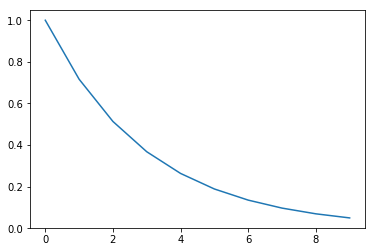

In [9]:
f, ax = plt.subplots()

lick_array = np.arange(0,10)
k=3
next_lick_p = [math.exp(-x*(1/k)) for x in lick_array]

ax.plot(lick_array, next_lick_p)



In [11]:
%who_ls dict

['lickdict', 'test1_data_NR', 'test1_data_PR']